In [1]:
from importlib import reload

import numpy as np
import pandas as pd
import seaborn as sns

import kaggle_hm.als_model
from kaggle_hm.chart_model import age_chart
from kaggle_hm.chart_model import filter_data
from kaggle_hm.config import data_root, train_dates, test_dates
from kaggle_hm.evaluation import compute_precision

In [2]:
reload(kaggle_hm.als_model)

<module 'kaggle_hm.als_model' from '/home/sstamenov/kaggle-hm/kaggle_hm/als_model.py'>

In [3]:
# using test customers in train set makes alg perform worse
# adding more history doesnt help

In [4]:
df = pd.read_parquet(data_root / 'clean' / 'transactions.parquet')
c = pd.read_parquet(data_root / 'clean' / 'customers.parquet').set_index('customer_id')
c['age'] = c['age'].fillna(c['age'].mean())
c['age_group'] = pd.cut(c['age'], bins=[15, 21, 25, 30, 40, 50, 60, 100])
df = df.merge(c, left_on='customer_id', right_index=True)

In [5]:
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_group
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"(21, 25]"
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"(21, 25]"
165807,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"(21, 25]"
6827145,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0578020002,0.013542,2,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"(21, 25]"
21953950,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0723529001,0.025407,2,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"(21, 25]"


In [6]:
delta = (pd.to_datetime('2020-09-08') - df['t_dat']).dt.days
df['delta_weeks'] = 1 / (1 + np.power(delta // 7, 1))

In [7]:
cols = [f'rel_{i + 1}' for i in range(12)]
test = filter_data(df, from_date=test_dates['start'], to_date=test_dates['end'])
train = filter_data(df, from_date='2020-09-01', to_date=train_dates['end'])
results = test.groupby('customer_id', observed=True).agg(bought=('article_id', set)).reset_index()
results = results.merge(c, left_on='customer_id', right_index=True)
old_customers = set(filter_data(df, to_date=train_dates['end'])['customer_id'].unique())

In [8]:
pred_ds = filter_data(df, to_date=train_dates['end'])

In [9]:
pipeline = kaggle_hm.als_model.MatrixFactorizationPipeline(min_items=1, min_customers=1, cell_value='time', factors=256, iterations=50, regularization=0.01)
pipeline.fit(train)
rec_df = pipeline.predict(pred_ds)

#items 20149
#customers 85300


  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
# custom predictions
train_items = pipeline.vectorizer.item_transformer.item_code.keys()
cond = (
    pred_ds['article_id'].isin(train_items) &
    pred_ds['customer_id'].isin(test['customer_id'].unique())
)
pred_transactions = pred_ds[cond].copy()

transformer = kaggle_hm.als_model.Transformer()
transformer.fit(pred_transactions['customer_id'].unique())
pred_transactions['customer_id'] = pred_transactions['customer_id'].map(transformer.item_code).astype('int')
X_pred = pipeline.vectorizer.transform(pred_transactions)

items, scores = pipeline.model.recommend(np.arange(X_pred.shape[0]), X_pred, N=100,
                                     filter_already_liked_items=False,
                                     recalculate_user=True)

candidates = pd.DataFrame(zip(items.flatten(), scores.flatten()), columns=['item_id', 'score'])
candidates['customer_id'] = (candidates.index // 100).map(transformer.code_item)
candidates['article_id'] = candidates['item_id'].map(pipeline.vectorizer.item_transformer.code_item)

In [40]:
test_nodup = test.drop_duplicates(subset=['customer_id', 'article_id'])

In [41]:
test_nodup.head()

,t_dat,customer_id,article_id,price,sales_channel_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_group,delta_weeks
31521960,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,0.061000,2,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"(21, 25]",inf
31492023,2020-09-14,0008968c0d451dbc5a9968da03196fe20051965edde741...,0893059004,0.035576,2,1.0,1.0,ACTIVE,Regularly,50.0,860a370c01b1eeebe3f3c78241f3236c79b0c41669c19e...,"(40, 50]",inf
31452519,2020-09-13,004888668b9458668aa3234d17337671673599f7f84d36...,0904026002,0.033881,2,1.0,1.0,ACTIVE,Regularly,23.0,063afae71598c3518f621e4a1224fef11de39f938d2d86...,"(21, 25]",inf
31452520,2020-09-13,004888668b9458668aa3234d17337671673599f7f84d36...,0897464002,0.025407,2,1.0,1.0,ACTIVE,Regularly,23.0,063afae71598c3518f621e4a1224fef11de39f938d2d86...,"(21, 25]",inf
31452521,2020-09-13,004888668b9458668aa3234d17337671673599f7f84d36...,0786579001,0.030492,2,1.0,1.0,ACTIVE,Regularly,23.0,063afae71598c3518f621e4a1224fef11de39f938d2d86...,"(21, 25]",inf


In [62]:
cand_ext = candidates.merge(test_nodup[['customer_id', 'article_id', 'price']], on=['customer_id', 'article_id'], how='left')

In [63]:
cand_ext['is_relevant'] = cand_ext['price'].notna().astype('int')

In [69]:
cand_ext['price'].notna().sum() / test_nodup.shape[0]

0.10908253257864947

In [64]:
cand_ext.query('is_relevant > 0').sample(n=20)

,item_id,score,customer_id,article_id,price,is_relevant
663138,517,0.195961,4306fb91e44f77a47ff5932735f19e01542ba680c6ad59...,0768912005,0.016932,1
6355762,1328,0.079703,2c3af25e66e766abdcdc78881009582e1999738779313d...,0915453003,0.033881,1
4761,5474,0.172565,06622cd3c0651f9046c91e4b7ffb15b113ae6d192214ec...,0916497001,0.022017,1
5535236,2504,0.045151,68b87a99b0e7c44eac3a5154a5e2e5dcf11778f8fccf81...,0728156006,0.050831,1
614828,2282,0.040533,d40d7a4814d037cbda20a540dfcd042f811d5b4f0fd1e0...,0708138037,0.067780,1
3496672,5,0.030864,149f366638a08c60577db75e4c5d2b12ef1046bb6ba398...,0456163086,0.033881,1
89509,2013,0.381514,7787b44e939a117c685f7f7cf7097b292852f04d0be28f...,0751471041,0.033881,1
4719849,179,0.013150,39fe1573be3f1653eeba9ea4d4304afec620460ef3e3d4...,0904416001,0.033881,1
3184201,6499,0.475946,2aa65149b3c2ecb366df4be7ac6f5b55aa320cd4fcbd5f...,0917300005,0.050831,1
285699,301,0.221961,aad78e472bf2e7e64a39392412793830de0c5087d0d1aa...,0900422001,0.042356,1


In [65]:
stats = cand_ext.groupby('customer_id').agg(total=('article_id', 'count'), hits=('is_relevant', 'sum'))

In [71]:
(stats['hits'] > 0).sum() / stats.shape[0]

0.26632289259865655

In [73]:
cand_ext.sort_values('customer_id').to_parquet(data_root / 'clean' / 'candidates.parquet')

In [34]:
top12_age_pred = age_chart(train)
comb = results.merge(rec_df, on='customer_id', how='left')
comb = comb.merge(top12_age_pred, on='age_group').drop(columns=['age_group'])
comb['prediction'] = comb['candidates'].combine_first(comb['naive_pred'])
cond = ~comb['customer_id'].isin(old_customers)
comb.loc[cond, 'segment'] = 'cold'

cond = comb['customer_id'].isin(old_customers)
comb.loc[cond, 'segment'] = 'old'

cond = comb['customer_id'].isin(train['customer_id'].unique())
comb.loc[cond, 'segment'] = 'train'
comb = compute_precision(comb)

In [35]:
comb['precision'].mean()

0.027632395962876324

In [36]:
comb[~comb['candidates'].isna()]['precision'].mean()

0.029560253428218473

In [37]:
d = comb.groupby('segment').agg(avg_p=('precision', 'mean'))['avg_p'].to_dict()
d

{'cold': 0.008500625450763665,
 'old': 0.016901669723500337,
 'train': 0.07042383424561427}

In [38]:
comb['segment'].value_counts()

old      51338
train    15286
cold      5395
Name: segment, dtype: int64

In [39]:
N = 1000
precisions = np.zeros(N)
for i in range(N):
    precisions[i] = comb.sample(n=1000)['precision'].mean()

In [40]:
pd.Series(precisions).describe()

count    1000.000000
mean        0.027681
std         0.003860
min         0.016362
25%         0.024862
50%         0.027437
75%         0.030385
max         0.040520
dtype: float64

<AxesSubplot:ylabel='Count'>

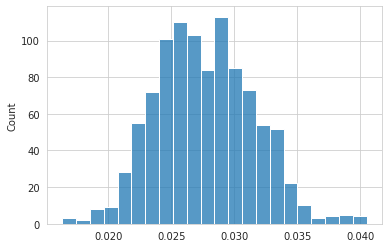

In [41]:
sns.histplot(precisions)

# Submission

In [42]:
submission = pd.read_csv('/data/sstamenov/kaggle-data/sample_submission.csv').drop(columns=['prediction'])
submission = submission.merge(c, left_on='customer_id', right_index=True)

In [43]:
submission.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"(40, 50]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"(21, 25]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"(21, 25]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"(50, 60]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"(50, 60]"


In [45]:
delta = (pd.to_datetime('2020-09-22') - df['t_dat']).dt.days
df['delta_weeks'] = 1 / (1 + np.power(delta // 7, 1))

In [46]:
full_ds = filter_data(df, to_date='2020-09-22')
train = filter_data(df, '2020-09-15', '2020-09-22')

In [47]:
pipeline = kaggle_hm.als_model.MatrixFactorizationPipeline(min_items=1, min_customers=1, cell_value='time', factors=256, iterations=50, regularization=0.01)
pipeline.fit(train)
rec_df = pipeline.predict(full_ds)

#items 18684
#customers 75481


  0%|          | 0/50 [00:00<?, ?it/s]

In [48]:
top12_age_pred = age_chart(train)
submission = submission.merge(rec_df, on='customer_id', how='left')
submission = submission.merge(top12_age_pred, on='age_group', how='left').drop(columns=['age_group'])
submission['prediction'] = submission['candidates'].combine_first(submission['naive_pred'])

In [49]:
submission['prediction'] = submission['prediction'].apply(lambda _: ' '.join(_))

In [50]:
submission[submission['prediction'].isna()]

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,0,1,2,...,5,6,7,8,9,10,11,candidates,naive_pred,prediction


In [51]:
submission.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,0,1,2,...,5,6,7,8,9,10,11,candidates,naive_pred,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,165.0,2800.0,1562.0,...,329.0,1917.0,301.0,579.0,1305.0,177.0,1794.0,"[0568601043, 0779781015, 0568601006, 085885600...","[0751471001, 0923758001, 0924243001, 092424300...",0568601043 0779781015 0568601006 0858856005 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,8712.0,924.0,4878.0,...,9231.0,1027.0,4309.0,4310.0,2325.0,4328.0,9779.0,"[0739590027, 0590928001, 0882759003, 088275700...","[0924243001, 0918522001, 0924243002, 091552900...",0739590027 0590928001 0882759003 0882757003 03...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,0.0,339.0,992.0,...,4948.0,2464.0,1911.0,1169.0,2887.0,4886.0,156.0,"[0794321007, 0805000001, 0805000008, 080500000...","[0924243001, 0918522001, 0924243002, 091552900...",0794321007 0805000001 0805000008 0805000007 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0924243001, 0928206001, 0930380001, 092424300...",0924243001 0928206001 0930380001 0924243002 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,1274.0,1682.0,296.0,...,192.0,1961.0,191.0,3946.0,1228.0,3619.0,1467.0,"[0896152002, 0730683050, 0791587015, 089615200...","[0924243001, 0928206001, 0930380001, 092424300...",0896152002 0730683050 0791587015 0896152001 07...


In [52]:
submission.shape[0]

1371980

In [53]:
submission[['customer_id', 'prediction']].to_csv('/data/sstamenov/kaggle-data/output/implicit_time_submission.csv', index=False)